In [1]:
import os

from pyspark.sql import SparkSession
# Initialize Spark session
spark = SparkSession.builder \
    .appName("SpookyAuthorIdentification") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.maxResultSize", "12g") \
    .getOrCreate()


# Load the CSV data into a Spark DataFrame
file_path = "train.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Reduce the size of the dataframe
# This was done because the Machine Learning algorithms were taking very long to run on the original dataset
df = df.sample(fraction=0.5, seed=42)

# Show the schema and the first few rows of the Spark DataFrame
df.printSchema()
df.show(5, truncate=False)


root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)

+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|id     |text                                                                                                                                                                                                                                                                                                                                                |author|
+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
from pyspark.ml.feature import Tokenizer

# Tokenize the text column
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
df_tokens = tokenizer.transform(df)

# Show the tokenized text
df_tokens.select("tokens").show(5, truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tokens                                                                                                                                                                                                                                                                                                                                                                                                            |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
from pyspark.ml.feature import StopWordsRemover

# Customize stopwords list to include pronouns
stopwords = StopWordsRemover.loadDefaultStopWords("english") + ['I', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her']

# Remove stopwords from the tokenized text
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=stopwords)
df_cleaned = remover.transform(df_tokens)

# Show the cleaned tokens
df_cleaned.select("filtered_tokens").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_tokens                                                                                                                                                                                                                                    |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[lovely, spring, looked, windsor, terrace, sixteen, fertile, counties, spread, beneath,, speckled, happy, cottages, wealthier, towns,, looked, former, years,, heart, cheering, fair.]                                                             |
|[surcingle, hun

In [4]:
#Stage 2 Feature Extraction

#import required functions
from pyspark.ml.feature import StopWordsRemover, Tokenizer
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

#TF-IDF calculation
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="vectorized_tokens")
idf = IDF(inputCol="vectorized_tokens", outputCol="tfidf")
normalizer = Normalizer(inputCol="tfidf", outputCol="normalized_features")

#The author column needed to be in numerical format for the machine learning algorithms later
indexer = StringIndexer(inputCol="author", outputCol="label")

#The dataframe has already gone through the tokenizer and remover steps at this point, so they don't need to
#be included in the pipeline
pipeline = Pipeline(stages=[vectorizer, idf, normalizer, indexer])

processed_data = pipeline.fit(df_cleaned).transform(df_cleaned)



In [5]:
# Stage 3 Machine Learning

# Random Forest
from pyspark.ml.classification import RandomForestClassifier

# Split the data
train_data, test_data = processed_data.randomSplit([0.8, 0.2], seed=42)

# Random Forest
# Used 100 trees and the normalized_features column that was developed
rf = RandomForestClassifier(labelCol="label", featuresCol="normalized_features", numTrees=100)
rf_model = rf.fit(train_data)

predictions = rf_model.transform(test_data)



In [6]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression

#Used the normalized_features column and 100 iterations
logistic_regression = LogisticRegression(featuresCol="normalized_features", labelCol="label", maxIter=50)

train_data, test_data = processed_data.randomSplit([0.8, 0.2], seed=42)


lr_model = logistic_regression.fit(train_data)

lr_predictions = lr_model.transform(test_data)

In [7]:
# Stage 4 Evaluation

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Random Forest Accuracy
accuracy = evaluator.evaluate(predictions)

print(f"Random Forest Accuracy = {accuracy:.2f}")

# Logistic Regression AccuracyLogistic Regression Accuracy =  0.60


lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy =  {lr_accuracy:.2f}")

#The MulticlassClassificationEvaluator was used to evaluate the two models. The metric used was accuracy,
#because this is a classification problem. The prediction needs to be compared to the actual label, so the accuracy
#is the percentage of correct predictions.

#The Random Forest accuracy was only 36%. This is only 3% more than random chance, since there are only three authors.
#Although that's technically better than random chance, its not enough better to be ok with the results. This was with 100 trees.
#We also tried it with lower and more amounts of trees, but the results for accuracy were all similar.

#The Logistic Regression Accuracy was much better, at 60%. This was way better than the 33% for random chance.
#This was done with 50 iterations. We also tried with fewer iterations but that yielded worse results. Increasing
#The number of iterations did not improve accuracy by that much.

Random Forest Accuracy = 0.36
Logistic Regression Accuracy =  0.60


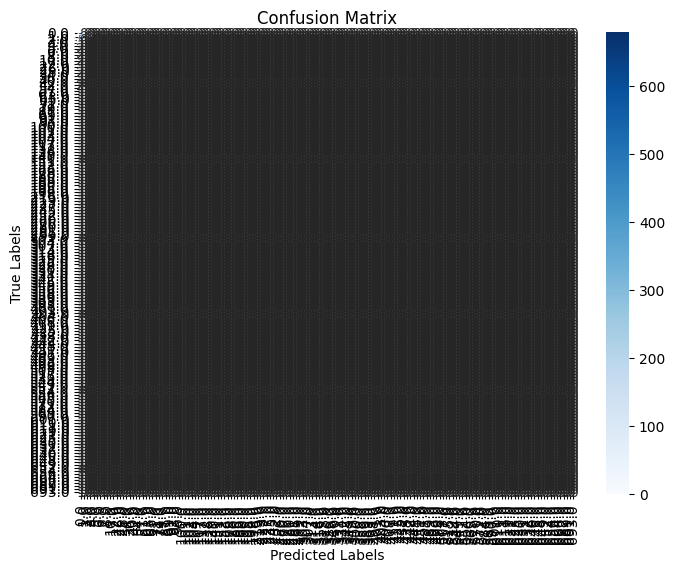

In [8]:
#Confusion matrix for Random Forest model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you already have predictions and labels in your Spark DataFrame (from SVM, Logistic Regression, etc.)
# Convert Spark DataFrame to Pandas DataFrame for compatibility with Scikit-learn
predictions_pd = predictions.select("label", "prediction").toPandas()

# Extract true labels and predicted labels
y_true = predictions_pd['label']
y_pred = predictions_pd['prediction']

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




In [9]:
!python --version

Python 3.10.12
